In [2]:
import os
os.chdir('../..')

## Analyse results

In [97]:
import numpy as np
import pandas as pd

#import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#stop-words
COMPANIES = ['aldi', 'rewe', 'miele', 'bmw', 'bosch', 'continental', 'daimler', 'magna', 'porsche', 'schaeffler', 'volkswagen', 'allianz', 'basf', 'cewe', 'db', 'deutsche', 'bahn', 'eon', 'evonik', 'henkel', 'miele', 'rewe']
stop_words=set(nltk.corpus.stopwords.words('english'))
stop_words.update(COMPANIES)


In [5]:
import srsly

In [6]:
from spacy.tokens import Doc
from typing import Iterable

ENT_IDS = [
    "DFG/Primary/GREEN_SUPPLY_CHAIN",
    "DFG/Primary/GREEN_RAZOR",
    "DFG/Primary/RECYCLING",
    "DFG/Primary/REUSING",
    "DFG/Secondary/GREEN_SUPPLY_CHAIN",
    "DFG/Secondary/GREEN_RAZOR",
    "DFG/Secondary/RECYCLING",
    "DFG/Secondary/REUSING",
]


def to_tsv(
    out_path: str,
    docs_items: Iterable[Doc],
    classifiers=["financial_tone", "sustainability_potential"],
):
    rows = []
    HEADER = [
        "TITLE",
        "ID",
        *["KEYWORDS_" + ent_id for ent_id in ENT_IDS],
        *[classifier for classifier in classifiers],
        "SENTENCE",
        *[f"COUNT_{ent_id}" for ent_id in ENT_IDS],
    ]
    for item in docs_items:
        for i, (sent, predictions) in enumerate(
            zip(
                item["sentences"],
                item.get("sentence_predictions", [[]] * item["n_sentences"]),
            )
        ):
            row = {
                "TITLE": item.get("title", ""),
                "ID": item.get("id", ""),
            }
            row.update(
                {
                    f"KEYWORDS_{ent_id}": ",".join(
                        [
                            ent["text"]
                            for ent in item["entities"]
                            if "id" in ent
                            and ent["id"] == ent_id
                            and ent["sent_ind"] == i
                        ]
                    )
                    for ent_id in ENT_IDS
                }
            )
            row.update({cls: predictions.get(cls, "") for cls in classifiers})
            row["SENTENCE"] = sent
            row.update(
                {
                    f"COUNT_{ent_id}": sum(
                        [
                            ent["id"] == ent_id and ent["sent_ind"] == i
                            for ent in item["entities"]
                            if "id" in ent
                        ]
                    )
                    for ent_id in ENT_IDS
                }
            )
            rows.append(row)
    df = pd.DataFrame(rows, columns=HEADER)
    df.to_csv(out_path)
    return df


# docs_items = nlp.pipe([(item["text"], item) for i, item in enumerate(items)], as_tuples=True)
# docs_items = documents_to_tsv("14012022_labeled_sentences.tsv")


In [7]:
from datetime import datetime
today = datetime.now().strftime('%Y%m%d')

In [8]:
from pathlib import Path
from datetime import datetime
# today = datetime.now().strftime('%Y%m%d')
# input_path = Path('corpus/dfg_paragraphs/other_sectors.jsonl')
# other_df = to_tsv(f'dfg_{input_path.name.split(".")[0]}_{today}.csv', srsly.read_jsonl(input_path))
# input_path = Path('corpus/dfg_paragraphs/automative_sector.jsonl')
# auto_df = to_tsv(f'dfg_{input_path.name.split(".")[0]}_{today}.csv', srsly.read_jsonl(input_path))

In [9]:
auto_df = pd.read_csv('dfg_automative_sector_20220121.csv', index_col=0)
auto_df['sector'] = 'auto'
other_df = pd.read_csv('dfg_other_sectors_20220121.csv', index_col=0)
other_df['sector'] = 'other'
df = pd.concat([other_df, auto_df], ignore_index=True)

In [10]:
import plotly.express as px

In [11]:
company_df = df.groupby(['TITLE','sector']).sum([f"COUNT_{ent_id}" for ent_id in ENT_IDS])

In [12]:
import re
def clean_text(headline):
    le = WordNetLemmatizer()
    word_tokens = word_tokenize(headline)
    tokens = [
        le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w) > 3 and re.match(r'[a-zA-Z]+\S*$', w)
    ]
    cleaned_text = " ".join(tokens)
    return cleaned_text.lower()

In [13]:
KEYWORD_COLUMNS = [f"KEYWORDS_{ent_id}" for ent_id in ENT_IDS]
df[KEYWORD_COLUMNS] = df[KEYWORD_COLUMNS].fillna('')
from collections import Counter

df_keywords = df.groupby(['TITLE', 'sector']).agg({col: lambda x: sorted(Counter(','.join([(clean_text(i)) for i in x if i]).split(',')).items(), key=lambda x: x[1], reverse=True) for col in KEYWORD_COLUMNS})
df_keywords.columns = ENT_IDS

In [14]:
top_df = company_df[[f"COUNT_{ent_id}" for ent_id in ENT_IDS]]
top_df.columns = ENT_IDS
top_df = pd.DataFrame(top_df.stack(), columns=["Occurance"])
top_df['keywords'] = df_keywords.stack()
top_df

Occurance  \
TITLE                            sector                                               
ALDI_Nord_Interim_Report_2020_EN other  DFG/Primary/GREEN_SUPPLY_CHAIN           50   
                                        DFG/Primary/GREEN_RAZOR                  15   
                                        DFG/Primary/RECYCLING                    14   
                                        DFG/Primary/REUSING                       6   
                                        DFG/Secondary/GREEN_SUPPLY_CHAIN         71   
...                                                                             ...   
miele_sustainability_report_2021 other  DFG/Primary/REUSING                       8   
                                        DFG/Secondary/GREEN_SUPPLY_CHAIN         80   
                                        DFG/Secondary/GREEN_RAZOR                90   
                                        DFG/Secondary/RECYCLING                  21   
                                        DFG/Secondary/REUSING                    15   

                                                                                                                   keywords  
TITLE                            sector                                                                                      
ALDI_Nord_Interim_Report_2020_EN other  DFG/Primary/GREEN_SUPPLY_CHAIN    [(supply chain, 27), (partnership, 4), (human ...  
                                        DFG/Primary/GREEN_RAZOR                [(system, 12), (reusable, 2), (returned, 1)]  
                                        DFG/Primary/RECYCLING             [(recycled, 9), (recycle, 3), (circular, 1), (...  
                                        DFG/Primary/REUSING               [(reusable, 2), (reused, 2), (reusing, 1), (re...  
                                        DFG/Secondary/GREEN_SUPPLY_CHAIN  [(packaging, 16), (international, 14), (respon...  
...                                                                                                                     ...  
miele_sustainability_report_2021 other  DFG/Primary/REUSING                     [(return, 4), (returned, 3), (reusable, 1)]  
                                        DFG/Secondary/GREEN_SUPPLY_CHAIN  [(international, 28), (packaging, 17), (respon...  
                                        DFG/Secondary/GREEN_RAZOR         [(machine, 51), (purchasing, 7), (handling, 7)...  
                                        DFG/Secondary/RECYCLING           [(manufacturing, 11), (reduce, 6), (reducing, ...  
                                        DFG/Secondary/REUSING             [(reduce, 10), (reducing, 2), (reduced, 2), (c...  

[152 rows x 2 columns]

In [15]:
top_df.sort_values(['TITLE', 'Occurance'], ascending=False).to_html('results/dfg/occurances.html')

In [16]:
fig = px.bar(company_df.reset_index(), x="TITLE", y=[f"COUNT_{ent_id}" for ent_id in ENT_IDS], facet_col="sector")
fig.update_xaxes(matches=None)
fig.update_layout(title="Absolute keyword occurances")
fig.write_html('results/dfg/absolute_keyword_document_occurance.html')
fig

In [17]:
fig = px.bar((company_df.apply(lambda x: 100*(x / company_df.sum(1)), axis=0)).reset_index(), x="TITLE", y=[f"COUNT_{ent_id}" for ent_id in ENT_IDS], facet_col="sector")
fig.update_xaxes(matches=None)
fig.update_layout(title="Percentual keyword occurances")
fig.write_html('results/dfg/percentual_keyword_document_occurance.html')
fig

## Text analysis

In [30]:
df['KEYWORDS'] = df[[f"KEYWORDS_{ent_id}" for ent_id in ENT_IDS]].apply(lambda x: ','.join([col for col in x if col]), 1).apply(lambda x: x.split(','), 0).apply(lambda x: [i for i in x if i != ''])

In [31]:
df = df[df['KEYWORDS'].apply(len) > 0]

In [32]:
nlp = spacy.load('en_core_web_sm')
df['KEYWORDS'] = df['KEYWORDS'].apply(lambda x: Doc(nlp.vocab, words=x, spaces=[True]*len(x)))

NameError: name 'spacy' is not defined

In [ ]:
import scattertext as st

# df['parse'] = df.SENTENCE.apply(st.whitespace_nlp_with_sentences)
corpus = st.CorpusWithoutCategoriesFromParsedDocuments(
    df, parsed_col='KEYWORDS'
).build()

corpus.get_categories()
# Returns ['_']

ValueError: [E030] Sentence boundaries unset. You can add the 'sentencizer' component to the pipeline with: `nlp.add_pipe('sentencizer')`. Alternatively, add the dependency parser or sentence recognizer, or set sentence boundaries by setting `doc[i].is_sent_start`.

In [47]:
corpus._df.parse

0        (we, report, on, this, and, other, progress, i...
1        (back, in, 2017, ,, aldi, nord, became, the, f...
2        (together, with, the, 17, united, nations, sus...
3        (i, hope, you, enjoy, reading, this, report, a...
4        (international, buying, aldi, einkauf, se, &, ...
                               ...                        
35948    (apart, from, hearing, impairment, ,, some, wo...
35949    (in, 2020, ,, only, 22, cases, of, potential, ...
35950    (zf, provides, the, required, skin, protection...
35951    (whenever, employees, suspect, they, are, expe...
35952    (all, employees, have, the, option, of, underg...
Name: parse, Length: 35953, dtype: object

In [38]:
dispersion = st.Dispersion(corpus)

dispersion_df = dispersion.get_df()
dispersion_df.head(3)

/home/oguz/.cache/pypoetry/virtualenvs/smart-evidence-hIlc30vc-py3.9/lib/python3.9/site-packages/scattertext/dispersion/Dispersion.py:55: RuntimeWarning:

divide by zero encountered in true_divide

/home/oguz/.cache/pypoetry/virtualenvs/smart-evidence-hIlc30vc-py3.9/lib/python3.9/site-packages/scattertext/dispersion/Dispersion.py:137: RuntimeWarning:

divide by zero encountered in true_divide



,Frequency,Range,SD,VC,Juilland's D,Rosengren's S,DP,DP norm,KL-divergence
we,5122,4736,0.381923,2.680845,0.984173,0.133862,0.859172,0.859172,2.977327
report,1079,901,0.206601,6.884085,0.959824,0.031498,0.965674,0.965674,5.112950
on,6986,6104,0.472259,2.430452,0.986633,0.194581,0.793930,0.793930,2.446286


In [39]:
dispersion_df = dispersion_df.assign(
    X=lambda df: df.Frequency,
    Xpos=lambda df: st.Scalers.log_scale(df.X),
    Y=lambda df: df["Rosengren's S"],
    Ypos=lambda df: st.Scalers.scale(df.Y),
)

In [41]:
html = st.dataframe_scattertext(
    corpus,
    plot_df=dispersion_df,
    metadata=corpus.get_df()['TITLE'] + ' (' + corpus.get_df()['sector'].str.upper() + ')',
    ignore_categories=True,
    x_label='Log Frequency',
    y_label="Rosengren's S",
    y_axis_labels=['More Dispersion', 'Medium', 'Less Dispersion'],
)

/home/oguz/.cache/pypoetry/virtualenvs/smart-evidence-hIlc30vc-py3.9/lib/python3.9/site-packages/scattertext/Scalers.py:212: RuntimeWarning:

invalid value encountered in true_divide



In [43]:
with open('test.html', 'w') as f:
    f.write(html)

In [44]:
html = st.dataframe_scattertext(
    corpus,
    plot_df=dispersion_df,
    metadata=corpus.get_df()['TITLE'] + ' (' + corpus.get_df()['sector'].str.upper() + ')',
    ignore_categories=True,
    x_label='Log Frequency',
    y_label="Rosengren's S",
    y_axis_labels=['More Dispersion', 'Medium', 'Less Dispersion'],
    color_score_column='ColorScore',
    header_names={'upper': 'Lower than Expected', 'lower': 'More than Expected'},
    left_list_column='Residual',
    background_color='#e5e5e3'
)

KeyError: 'speaker'

In [21]:
import spacy
from scattertext import SampleCorpora, PhraseMachinePhrases, dense_rank, RankDifference, AssociationCompactor, produce_scattertext_explorer
from scattertext.CorpusFromPandas import CorpusFromPandas

corpus = (CorpusFromPandas(df,
                           category_col='sector',
                           text_col='SENTENCE',
                           feats_from_spacy_doc=PhraseMachinePhrases(),
                           nlp=spacy.load('en_core_web_sm', disable='parser'))
          .build().compact(AssociationCompactor(4000)))

html = produce_scattertext_explorer(corpus,
                                    category='democrat',
                                    category_name='Democratic',
                                    not_category_name='Republican',
                                    minimum_term_frequency=0,
                                    pmi_threshold_coefficient=0,
                                    transform=dense_rank,
                                    metadata=corpus.get_df()['speaker'],
                                    term_scorer=RankDifference(),
                                    width_in_pixels=1000)

KeyError: 'speaker'

# LSA & LDA

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#stop-words
stop_words=set(nltk.corpus.stopwords.words('english'))

In [114]:
for document in df_documents.itertuples():
    with open(f'results/dfg/documents/{document.title}.txt', 'w') as file:
        file.write(document.text)

In [99]:
from itertools import chain
paragraphs = (chain(srsly.read_jsonl('corpus/dfg_paragraphs/other_sectors.jsonl'), srsly.read_jsonl('corpus/dfg_paragraphs/automative_sector.jsonl')))
df_paragraphs = pd.DataFrame(paragraphs)
documents = (chain(srsly.read_jsonl('corpus/dfg_documents/other_sectors.jsonl'), srsly.read_jsonl('corpus/dfg_documents/automative_sector.jsonl')))
df_documents = pd.DataFrame(documents)

In [100]:
import re
def clean_text(headline):
    le = WordNetLemmatizer()
    word_tokens = word_tokenize(headline)
    tokens = [
        le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w) > 3 and re.match(r'[a-zA-Z]+\S*$', w)
    ]
    cleaned_text = " ".join(tokens)
    return cleaned_text


In [101]:
df_paragraphs['clean_text'] = df_paragraphs.text.apply(clean_text)
df_documents['clean_text'] = df_documents.text.apply(clean_text)

In [102]:
vect =TfidfVectorizer(stop_words=stop_words,min_df=2, max_df=20) # to play with. min_df,max_df,max_features etc...
# vect_text=vect.fit_transform(df_paragraphs['clean_text'])
vect_text=vect.fit_transform(df_documents['clean_text'])

In [103]:
len(vect.get_feature_names_out())

8219

In [104]:
idf=vect.idf_
dd=dict(zip(vect.get_feature_names_out(), idf))
l=sorted(dd, key=(dd).get)
# print(l)
print(l[0],l[-1])

able zwickau


In [105]:
from sklearn.decomposition import TruncatedSVD
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)

In [106]:
df_paragraphs[[f'lsa_{i}' for i in range(10)]] = lsa_top

ValueError: Length of values (19) does not match length of index (11255)

In [ ]:
np.argsort(df_paragraphs.groupby(['title']).sum([f'lsa_{i}' for i in range(10)])[[f'lsa_{i}' for i in range(10)]], 1)

,lsa_0,lsa_1,lsa_2,lsa_3,lsa_4,lsa_5,lsa_6,lsa_7,lsa_8,lsa_9
title,,,,,,,,,,
ALDI_Nord_Interim_Report_2020_EN,7,5,6,8,1,3,0,9,4,2
Allianz_Group_Sustainability_Report_2020-web,6,5,7,9,2,1,8,0,3,4
Audi 2020,5,6,2,7,9,8,3,0,4,1
BMW-Group-Bericht-2020-EN,5,6,7,9,2,8,0,1,3,4
CEWE_Sustainability_Report_2020_safe_01,5,6,7,9,2,1,8,0,4,3
Continental-2020,5,7,8,9,2,1,0,3,6,4
Deutsche Bahn 2020,5,6,9,7,8,2,1,0,3,4
EON_2020_Sustainability_Report,5,6,7,9,2,8,1,0,3,4
Evonik_Sustainability Report 2020,7,9,8,2,1,6,0,3,5,4


In [ ]:
lsa_top.shape

(19, 10)

In [ ]:
# most important words for each topic
vocab = vect.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")
         


Topic 0: 
group also management employee product company year sustainability business risk 

Topic 1: 
product henkel cent packaging sustainability bosch nord percent waste store 

Topic 2: 
porsche audi group cent volkswagen store brand also vehicle schaeffler 

Topic 3: 
porsche audi bosch magna allianz percent employee energy customer sport 

Topic 4: 
audi bosch volkswagen schaeffler percent electric magna vehicle energy associate 

Topic 5: 
schaeffler group bosch porsche allianz energy volkswagen management associate climate 

Topic 6: 
bosch associate continental also robert basf company want covid19 year 

Topic 7: 
allianz group asset investment insurance cent climate store risk volkswagen 

Topic 8: 
magna bosch cent group vehicle including supply store program nord 

Topic 9: 
continental allianz schaeffler cent audi remuneration nord bosch executive risk 



### LDA

In [78]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 
# n_components is the number of topics

In [119]:
lda_top=lda_model.fit_transform(vect_text)

In [120]:
# most important words for each topic
vocab = vect.get_feature_names()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:20]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
report currently audit information social financial statement programme medium respective group rate audi fleet risk annual introduced chapter virtual section 

Topic 1: 
location remuneration year sale throughout component every euro regarding million previous found fiscal additional purpose independent combined instrument financial report 

Topic 2: 
porsche volkswagen vehicle car security battery engine existing consumption hybrid fuel donation another technical industrial expanded organisation module model energy 

Topic 3: 
board order schaeffler supervisory software risk workforce integrity executive implemented group expected representative provided member must management measure committee taken 

Topic 4: 
porsche electric accident situation charging crisis service format event series magna offer first europe mobility online sport taycan collaboration family 

Topic 5: 
emission million year carbon continental target period scope percent covid reduction 19 bosch term 

### T-sne

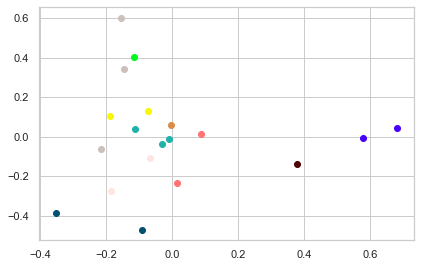

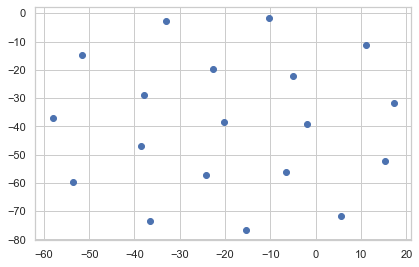

In [77]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

tf_idf_vectorizer = TfidfVectorizer(analyzer="word", use_idf=True, smooth_idf=True, ngram_range=(1, 3), max_df=0.5, min_df=5)
tf_idf_matrix = tf_idf_vectorizer.fit_transform(df_documents.text)

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
)

labels = clustering_model.fit_predict(tf_idf_matrix)
# print labels

X = tf_idf_matrix.todense()

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
# print reduced_data

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()



# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

## Keyword extraction

In [23]:
# script.py
from keybert import KeyBERT

kw_model = KeyBERT()

In [24]:
from scripts.components.keyword_ruler import get_keywords_from_globsb


In [56]:
KEYWORD_GLOBS = [
    "assets/keywords_clean/DFG/**/*.tsv",
]
keywords = get_keywords_from_globs(KEYWORD_GLOBS)
keywords = [k['keyword'] for k in keywords]
keywords[:10]

['3r',
 'circular network',
 'circular',
 'refurbished',
 'reduce',
 'closed loop',
 'refurbishment',
 'waste reduction',
 'circulation',
 'environmental issues']

In [115]:
sample_df_paragraphs = df_paragraphs.sample(100)
sample_df_paragraphs['predicted_keywords'] = kw_model.extract_keywords(sample_df_paragraphs['clean_text'], keyphrase_ngram_range=(1, 1), use_mmr=True, stop_words=COMPANIES, seed_keywords=keywords)

In [116]:
sample_df_paragraphs.sort_values('title')[['title', 'text', 'predicted_keywords']].to_html('results/dfg/predicted_keywords_sample.html')

In [44]:
from itertools import chain
for item in df_paragraphs:
    print(item['title'])
    print()
    print()

ALDI_Nord_Interim_Report_2020_EN
[('sustainability strategies', 0.5494), ('united nations', 0.4871), ('discount food', 0.4024), ('goals sdgs', 0.3112), ('retailer to', 0.3388)]

ALDI_Nord_Interim_Report_2020_EN
[('buying einkauf', 0.4397), ('co2 emissions', 0.3921), ('paris agreement', 0.3811), ('verified targets', 0.304), ('2022', 0.2915)]

ALDI_Nord_Interim_Report_2020_EN


KeyboardInterrupt: 

In [36]:
pwd

'/home/oguz/Workspace/smart-evidence'